In [21]:
from collections import namedtuple
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import odeint, cumtrapz
from scipy.optimize import minimize

In [22]:
t_motor_max = (75 / 1000) * 9.81 * 0.1 # [Nm] 540 80t motor
print(t_motor_max)
t_motor_max = 8.5 * 9.81 / 100 # [Nm] pololu motor
print(t_motor_max)

omega_motor_max = 530 # [rev/min]
gear_ratio = 915 # [-]

height_balcony = 5 # [m]
time_max = 5 # [s]

diam_drum = 0.25 # [m]
circ_drum = diam_drum * np.pi # [m]

lift_capacity = 10 # [kg]

0.073575
0.8338500000000001


In [23]:
# Calculate Max Load based on Desired Time
speed_avg_rq = height_balcony / time_max
omega_avg_rq_rps = speed_avg_rq / diam_drum
omega_avg_rq_rpm = omega_avg_rq_rps * 60

gear_ratio_rq = omega_motor_max / omega_avg_rq_rpm

max_load = (gear_ratio_rq * t_motor_max) / diam_drum / 9.81
print('The max load to achieve the desired lift time is:', max_load)

The max load to achieve the desired lift time is: 0.7508333333333335


In [24]:
# Calculate time required based on lift capacity
lift_capacity_drum_torque = lift_capacity * 9.81 * diam_drum

lift_cap_gear_ratio = lift_capacity_drum_torque / (t_motor_max * 0.5)
lift_cap_omega_rq_rpm = (omega_motor_max * 0.5) / lift_cap_gear_ratio
lift_cap_omega_rq_rps = lift_cap_omega_rq_rpm / 60

lift_cap_speed_m_s = lift_cap_omega_rq_rps * diam_drum
min_lift_time = height_balcony / lift_cap_speed_m_s

print('Min time to lift:', min_lift_time)

Min time to lift: 266.37069922308547


In [25]:
# Calculate required motor specs for given performance
print('Motor specs per {} [s] lift time and {} [kg] payload\n{:.2f} [Nm] @ {} [rpm]\n{:.2f} [oz-in]\n{} [kg-m]'.format(time_max, lift_capacity, lift_capacity_drum_torque, omega_avg_rq_rpm, lift_capacity_drum_torque * 141.61193, lift_capacity_drum_torque / 9.81))

Motor specs per 5 [s] lift time and 10 [kg] payload
24.53 [Nm] @ 240.0 [rpm]
3473.03 [oz-in]
2.5 [kg-m]


In [26]:
# simulate and tune closed loop control

m = 100/1000 # [kg]

j1 = 4.90900e-7 # [kg-m^2]
j2 = 0.02485 # [kg-m^2]

g = 9.81

dt = 0.1
t_start = 0
t_end = 100

n_samples = int((t_end-t_start) / dt)

tS = np.linspace(t_start, t_end, n_samples)

def tau_ramp_up(t):
    if t < 5:
        return (20*t - 100)
    else:
        return 0
    
def tau_ramp_down(t):
    if t < 2.5:
        return (-2*t + 10)
    else:
        return 0

def worm_model(U, t, V, P):
    """
    Some notes on the worm drive model
    
    Test Cases
    # ID | Desc | Expected Results
    # T01 | 0 mass; 0 torque; U0 = 0 | everything stays static
    # T02 | mass != 0; torque > overcoming torque; U0 = 0 | omega_a becomes positive, omega_b becomes negative scaled by eta
    # T03 | mass; torque < overcoming torque; U0[omega_a,b] != 0 | system slows to stop. Stays stopped.
    # T04 | Complement to T02 (raising)-> Lowering | system lowers faster than raises
    --- The above four tests pass ---
    # T05 | mass; torque > overcoming toruqe | mass follows rope (seems to pass)
    # T05 | mass; s_dot_dot > g | rope position goes ahead of mass position
    # T06 | mass != 0; ramp tau from negative to zero | non-constant acceleration; eventually all states stop -> FAIL
    """
    # U = theta_a, omega_a, theta_b, omega_b, s, s_dot
    # _a: pinion / drive gear
    # _b: ring / reduction gear
    # s: unwound length of rope
    g = 9.81 # m/s^2
    
    i = U[0]
    theta_a = U[1]
    omega_a = U[2]
    theta_b = U[3]
    omega_b = U[4]
    s = U[5]
    s_dot = U[6]
    r = U[7]
    r_dot = U[8]
    
    # Circuit Model
    tau_m = P.motor_k * i
    F = tau_m / (P.eta * P.r_drum)
    
    # TODO: create circuit model as independent function or class
    i_dot = 1 / P.motor_l * (V - omega_a - P.motor_r * i)
    dP_dt = (tau_m + tau_m / (P.j_b * P.eta * P.r_drum) - (P.eta * P.m * g) / (P.j_a)) / (1 + (P.j_b / P.j_a) * P.eta**2)
    dQ_dt = (F - P.m*g) / P.m

    
    # Rolling up motor
    # consider a "smooth" case where alpha_a cannot increase while the "overcoming torque" is too low.
    # This covers the scenario when the gear slows below the overcoming torque and when the motor is stalled
    # The final condition would be that if omega_a cannot become negative while tau_m >= 0
    #      alpha_a = min(0, alpha_a) -> speed can only stay the same or slow down. Therefore alpha <= 0.
    #      omega_a = max(omega_a, 0) -> Gear cannot be backdriven by load. Therefore omega >= 0.
    # I think the above covers ALL cases where tau_m >=0 & "overcoming torque" is below the threshold.
    
    # calculate common flags
    OVERCOMING_TORQUE = abs(tau_m * P.eta) >= (P.m * g * P.r_drum)
    
    # calculate drum dynamics
    # Need to ensure omega -> 0 when tau_m == 0
    # FIXME: There is no damping in the current geartrain. It will spin continuosly at the previous speed
    #   despite the input torque being taken away. This also ignores the fact that when the input torque to
    #   screw-drive goes to zero, this will effectively halt the entire gear train, acting somewhat like a brake.
    # TODO: Add damping terms
    alpha_a = (1 / (1 + (P.j_b)/(P.eta**2 * P.j_a))) * (tau_m/P.j_a - (P.m * g * P.r_drum) / (P.eta * P.j_a))
    
    if (not OVERCOMING_TORQUE) and (tau_m > 0):
        # This is the case where there is a non-zero input torque, but it is below the minimum threshold to overcome
        # the torque created by the bucket mass. 
        omega_a = max(0, omega_a)
        alpha_a = min(0, alpha_a) * (omega_a > 0) # ensure that alpha_a not > 0 via min and stays stopped (omega_a == 0)
    elif (tau_m == 0):
        # This is a made up hack as a work around for the fact that there is no damping in the system. It ensures that
        # the system quickly comes to a stop when there is zero input torque. It would be better to consider some very
        # high resistance force to any backdriving.
        #
        # More generally in the future, when the motor torque is zero, ensure the system can't be backdriven!
        alpha_a = -10 * omega_a

            
    # Derived ODEs    
    alpha_b = -alpha_a / P.eta
    omega_b = -omega_a / P.eta
    
    # rope dynamics
    s_dot_dot = -alpha_b * np.pi * P.r_drum
    
    
    # The 
    # calculate mass dynamics
    # if the natural length of rope is unwinding faster than gravity, the bucket will be in free fall
    if s_dot_dot < -g:
        r_dot_dot = -g
    # if rope unrolling acceleration is slower than gravity, but s is still ahead of r, the bucket is still in free fall
    elif (s_dot_dot >= g) or (s < r):
        r_dot_dot = -g
    # Special case when bucket is quickly stopped by reaching r == s after bucket free fall.
    # In the future, this impulse can be considered: For the infinitely stiff rope it would have a brief, strong impact
    #   on the lifting acceleration if s is moving. Else it would dead stop. In the case of a rope with spring like properties
    #   this would lead to some bouncing.
    # FIXME: There are a few issues going on here
    #   (1) In the case for starting position of x negative and using a positive torque to lift the bucket, but ramp the
    #       torque down to zero, the rope tip velocity s_dot goes to zero and the rope tip position, s, is static. The bucket
    #       continues flying up and is parabolically slowed by gravity. This is fine until the bucket reaches the rope length.
    #       The bucket abruptly stops at the rope position with accel going to zero and position freezing, but the speed
    #       Doesn't appropraiately ramp to zero.
    #   (2) Hacking the above case needs to be double checked against the scenario to ensure that the bucket doesn't travel
    #       s and that no bouncing occurs for the infinitely stiff rope. Somehow the speed needs to quickly accelerate to 0
    #       as well.
    elif (r <= s) and (r_dot != s_dot):
        r_dot_dot = -1000 * r_dot
    # nominal case
    else:
        r_dot_dot = s_dot_dot
        r_dot = s_dot
    
    return [i_dot, omega_a, alpha_a, omega_b, alpha_b, s_dot, s_dot_dot, r_dot, r_dot_dot]

def sim(P):
    # simple simulation wrapper for a PID controller
    
    # history containers
    iS = list()
    theta_aS = list()
    omega_aS = list()
    sS = list()
    s_dotS = list()
    rS = list()
    r_dotS = list()
    VS = list()
    
    # mechanical parameters
    r1 = 20 / 1000 # diam of gear1 [m]
    r2 = 200 / 1000 # diam of gear2 [m]
    eta = r1 / r2 # gear ratio [-]
    r_drum = 100 / 1000 # diam of rope drum [m]
    
    # electrical parameters
    R = 3 # motor resistence [Ohm]
    L = 0.1 # motor inductance [H]
    k = 1 / 50 # motor torque constant [Nm / A]
    
    # TODO: When creating electrical system as own model -> improve the location of these parameters
    WormParams = namedtuple('WormParams', 'eta j_a j_b r_a r_b m r_drum R L k')

    P_worm = WormParams(eta = 50, # gear ratio
                        j_a = 0.1, # intertia of input gear
                        j_b = 10, # intertia of output gear
                        r_a = 0.05, # radius of input gear
                        r_b = 0.3, # radius of output gear
                        m = 2.5, # mass of bucket
                        r_drum = 0.1, # radius of drum
                        R = 3, # motor resistance [Ohm]
                        L = 0.1, # motor inductance [H]
                        k = 1 / 50 # motor torque constant [Nm / A]
                       )
    
    # controller gains
    kp = P[0]
    ki = P[1]
    kd = P[2]
    kd = 0
    
    s = -5 # released rope length [m]
    s_dot = 0 # d/dt(unspooled rope length) [m/s]
    r = s # bucket vertical position [m]
    r_dot = s_dot # bucket vertical velocity [m/s]
    
    V = 0 # motor voltage [v]
    i = 0 # motor current [A]
    
    theta_a = 0 # drum angular position [rad]
    omega_a = 0 # drum angular rate [rad/s]
    
    for j in range(n_samples):
        # store histories
        iS.append(i)
        theta_aS.append(theta_a)
        omega_aS.append(omega_a)
        sS.append(s)
        s_dotS.append(s_dot)
        rS.append(r)
        r_dotS.append(r_dot)
        VS.append(V)
                
        V = -kp * s - ki * sum(sS) - kd * s_dot

        V_MAX = 24
        V = min(max(-V_MAX, V), V_MAX) # voltage limit
        U_step = [i, theta_a, omega_a, -theta_a / P_worm.eta, -omega_a/P_worm.eta, s, s_dot, r, r_dot]
        U = odeint(worm_model, U_step, tS, (V, P_worm))

        I_MAX = 30
        i = min(float(U[:,0][1]), I_MAX) # current limit
        theta_a = float(U[:,1][1])
        omega_a = float(U[:,2][1])
        theta_b = float(U[:,3][1])
        omega_b = float(U[:,4][1])
        s = float(U[:,5][1])
        s_dot = float(U[:,6][1])
        r = float(U[:,7][1])
        r_dot = float(U[:,8][1])
        
    torqueS = np.array(iS) * np.array(k)
    FS = torqueS / (P_worm.r_drum * P_worm.eta)
    
    return iS, theta_aS, omega_aS, sS, s_dotS, rS, r_dotS, VS, torqueS, FS

def min_sim(P):
    iS, theta_aS, omega_aS, sS, s_dotS, rS, r_dotS, VS, torqueS, FS = sim(P)
    return sum(abs(np.array(rS)))

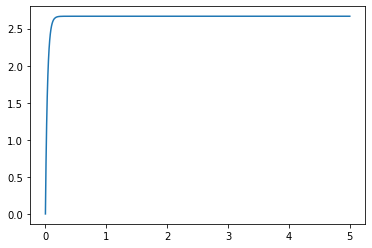

In [27]:
def circuit_model(U, t, V):
    L = 0.1
    R = 3
    i = U[0]
    
    i_dot = 1 / L * (V - R * i)
    
    return i_dot
    
tS = np.linspace(0, 5, int(5/0.01))

U = odeint(circuit_model, [0], tS, (8,))

fig, ax1 = plt.subplots()
ax1.plot(tS, U[:,0])

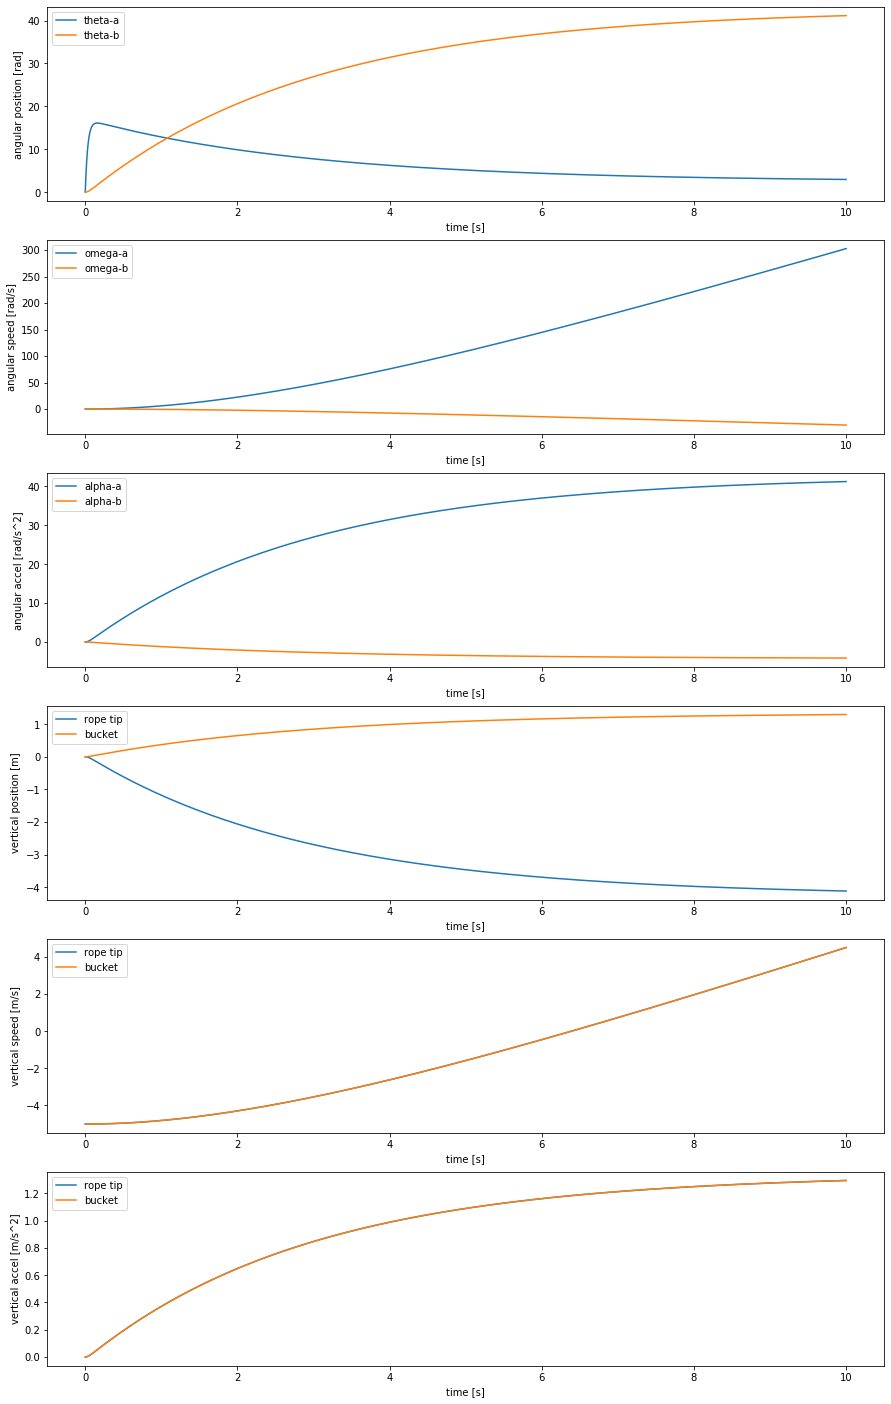

In [31]:
# testing the basic gear ODE
t_end = 10
dt = 0.01

tS = np.linspace(0, t_end, int(t_end/dt))

WormParams = namedtuple('WormParams', 'motor_k motor_l motor_r eta j_a j_b r_a r_b m r_drum')

P_worm = WormParams(motor_k = 1 / 5,
                    motor_l = 0.1,
                    motor_r = 3,
                    eta = 10,
                    j_a = 0.1,
                    j_b = 10,
                    r_a = 0.05,
                    r_b = 0.3,
                    m = 5,
                    r_drum = 0.1
                   )

# U: theta-a, omega-a, theta-b, omega-b, s, s_dot, r, r_dot
i_init = 0
theta_init = 0
omega_init = 0
s_init = -5
s_dot_init = 0
r_init = s_init
r_dot_init = 0
motor_torque = 50

U0 = [i_init, theta_init, omega_init, -theta_init / P_worm.eta, -omega_init/P_worm.eta, s_init, s_dot_init, r_init, r_dot_init]

U = odeint(worm_model, U0, tS, (motor_torque, P_worm))

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6,1, figsize=(15,25))

ax1.plot(tS, U[:,0], label='theta-a')
ax1.plot(tS, U[:,2], label='theta-b')
ax1.set_xlabel('time [s]')
ax1.set_ylabel('angular position [rad]')
ax1.legend(loc='best')

ax2.plot(tS, U[:,1], label='omega-a')
ax2.plot(tS, U[:,3], label='omega-b')
ax2.set_xlabel('time [s]')
ax2.set_ylabel('angular speed [rad/s]')
ax2.legend(loc='best')

ax3.plot(tS, np.gradient(U[:,1], dt), label='alpha-a')
ax3.plot(tS, np.gradient(U[:,3], dt), label='alpha-b')
ax3.set_xlabel('time [s]')
ax3.set_ylabel('angular accel [rad/s^2]')
ax3.legend(loc='best')

ax4.plot(tS, U[:,4], label='rope tip')
ax4.plot(tS, U[:,6], label='bucket')
ax4.set_xlabel('time [s]')
ax4.set_ylabel('vertical position [m]')
ax4.legend(loc='best')

ax5.plot(tS, U[:,5], label='rope tip')
ax5.plot(tS, U[:,7], label='bucket')
ax5.set_xlabel('time [s]')
ax5.set_ylabel('vertical speed [m/s]')
ax5.legend(loc='best')

ax6.plot(tS, np.gradient(U[:,5], dt), label='rope tip')
ax6.plot(tS, np.gradient(U[:,7], dt), label='bucket')
ax6.set_xlabel('time [s]')
ax6.set_ylabel('vertical accel [m/s^2]')
ax6.legend(loc='best')

plt.show()